# Great Energy Predictor - EDA

<a id='content2'></a>
## Content

1. [Data Description](#description2)
2. [Imports](#imports2)
3. [Exploratory Analysis](#eda)
    - [Building Analysis](#eda_bldg)
    - [Weather Analysis](#eda_wthr)
    - [Meter Analysis](#eda_metr)

<a id='description2'></a>
## 1. Data Description
[Back to top](#content2)

The data is a 2016 collection of energy meter readings (from over 1,000 buildings in 16 sites around the world) and weather measurements (from the nearest weather station for each site). It consists of 3 relational files of tabular data with the following features:
##### 1. train.csv - contains energy consumption measurements from 4 types of building meters in 2016
    - building_id - identifies the building
        - There are 1449 buildings in 16 sites around the world in this dataset
    - meter - meter type (not all buildings have all meter types)
        - 0 - electricity
        - 1 - chilldwater
        - 2 - steam
        - 3 - hotwater
    - timestamp - date and time of the meter reading
        - This dataset contains measurements over a span of an entire year
    - meter_reading - Energy consumption, in kilowatt-hour (kWh) or equivalent
        - This is the target variable
##### 2. weather_train.csv - contains weather measurements in 2016 from the weather station that is closest to the site
    - site_id - identifies the site where the building is
    - timestamp - date and time of the weather measurements
    - air_temperature - air temperature, in degrees Celsius
    - cloud_coverage - portion of the sky covered by clouds, in oktas
    - dew_temperature - temperature at which dew forms, in degrees Celsius
    - precip_depth_1_hr - measure of rainfail in 1 hour, in millimeters (mm)
    - sea_level_pressure - atmospheric pressure at sea level, in millibar (mbar) or hectopascals (hPa)
    - wind_direction - compass direction of the wind (0 - 360)
    - wind_speed - wind speed, in meters per second (m/s)
##### 3. building_metadata.csv - contains details about the buildings in the dataset
    - site_id - identifies the site where the building is
    - building_id - identifies the building
    - primary_use - what the building is used for (based on EnergyStar's property types)
    - square_feet - gross floor area of the building, in square feet (ft^2)
    - year_built - year the building was opened
    - floor_count - number of floors the building has
    
This data was retrieved from a public Kaggle competition hosted by ASHRAE.
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction/data

<a id='imports2'></a>
## 2. Imports
[Back to top](#content2)

##### Import libraries

In [1]:
import gc
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

# import stumpy
# from fbprophet import Prophet as fb
# import plotly
# import ray.dataframe as pd

%matplotlib inline

In [2]:
plt = mpl.pyplot

# Default plot settings
sns.set(rc={'figure.figsize': (16, 4), 
            'font.size': 12})

##### Import data

In [3]:
dtypes = {
    'site_id': 'uint8',
    'building_id': 'uint16',
    'primary_use': 'category',
    'square_feet': 'uint32',
    'year_built': 'uint16',
    'floor_count': 'uint8',
    'in_construction': 'uint8'
}

In [4]:
building = pd.read_csv('../data/clean/clean_building.csv', dtype=dtypes)
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 8 columns):
Unnamed: 0         1449 non-null int64
site_id            1449 non-null uint8
building_id        1449 non-null uint16
primary_use        1449 non-null category
square_feet        1449 non-null uint32
year_built         1449 non-null uint16
floor_count        1449 non-null uint8
in_construction    1449 non-null uint8
dtypes: category(1), int64(1), uint16(2), uint32(1), uint8(3)
memory usage: 29.2 KB


In [5]:
dtypes = {
    'site_id': 'uint8',
    'air_temperature': 'float32',
    'cloud_coverage': 'uint8',
    'dew_temperature': 'float32',
    'precip_depth_1_hr': 'float32',
    'sea_level_pressure': 'float32',
    'wind_direction': 'uint16',
    'wind_speed': 'float32'
}

In [6]:
weather = pd.read_csv('../data/clean/clean_weather.csv', dtype=dtypes, parse_dates=['timestamp'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 10 columns):
Unnamed: 0            140544 non-null int64
site_id               140544 non-null uint8
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float32
cloud_coverage        140544 non-null uint8
dew_temperature       140544 non-null float32
precip_depth_1_hr     140544 non-null float32
sea_level_pressure    140544 non-null float32
wind_direction        140544 non-null uint16
wind_speed            140544 non-null float32
dtypes: datetime64[ns](1), float32(5), int64(1), uint16(1), uint8(2)
memory usage: 5.4 MB


In [7]:
dtypes = {
    'building_id': 'uint16',
    'meter': 'uint8',
    'meter_reading': 'float32',
    'type': 'category'
}

In [8]:
meter = pd.read_csv('../data/clean/clean_meter.csv', dtype=dtypes, parse_dates=['timestamp'])
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 6 columns):
Unnamed: 0       int64
building_id      uint16
meter            uint8
timestamp        datetime64[ns]
meter_reading    float32
type             category
dtypes: category(1), datetime64[ns](1), float32(1), int64(1), uint16(1), uint8(1)
memory usage: 462.7 MB


In [9]:
# Drop the 1st column
building.drop('Unnamed: 0', axis=1, inplace=True)
weather.drop('Unnamed: 0', axis=1, inplace=True)
meter.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
del dtypes
gc.collect()

1294

<a id='eda'></a>
## 3. Exploratory Analysis
To:
- [Building Analysis](#eda_bldg)
- [Weather Analysis](#eda_wthr)
- [Meter Analysis](#eda_metr)
- [Top](#content2)

<a id='eda_bldg'></a>
### Building Analysis
[Back to 3. Exploratory Analysis](#eda)

# CHECK MISSING TIMESTAMPS IN METER DATA

##### Inspect the data

In [11]:
building.describe()

site_id  building_id    square_feet   year_built  floor_count  \
count  1449.000000  1449.000000    1449.000000  1449.000000  1449.000000   
mean      6.952381   724.000000   92111.776398  1967.115252     3.557626   
std       5.003432   418.434583  110769.950997    21.768143     3.371705   
min       0.000000     0.000000     283.000000  1900.000000     1.000000   
25%       3.000000   362.000000   23012.000000  1961.000000     1.000000   
50%       5.000000   724.000000   57673.000000  1964.000000     2.000000   
75%      13.000000  1086.000000  115676.000000  1973.000000     4.000000   
max      15.000000  1448.000000  875000.000000  2017.000000    26.000000   

       in_construction  
count      1449.000000  
mean          0.005521  
std           0.074124  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           1.000000

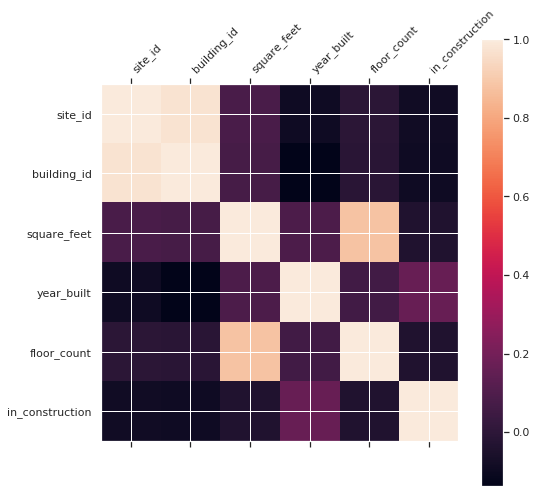

In [12]:
fig = plt.figure(figsize=(8, 8))

plt.matshow(building.corr(), fignum=fig.number)
plt.yticks(range(building.corr().shape[0]), building.corr().columns)
plt.xticks(range(building.corr().shape[0]), building.corr().columns, rotation=45, ha='left')
plt.colorbar()

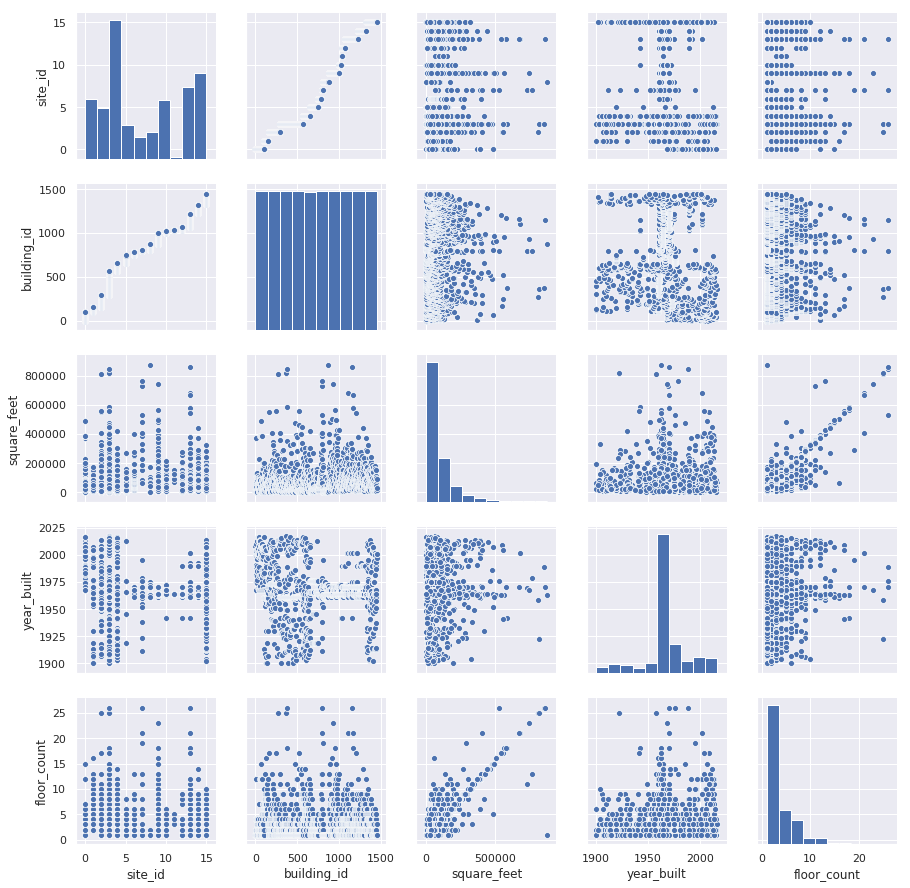

In [13]:
sns.pairplot(building.drop('in_construction', axis=1))

##### Visualize the data by site

Text(0.5, 1.0, 'Buildings in each site')

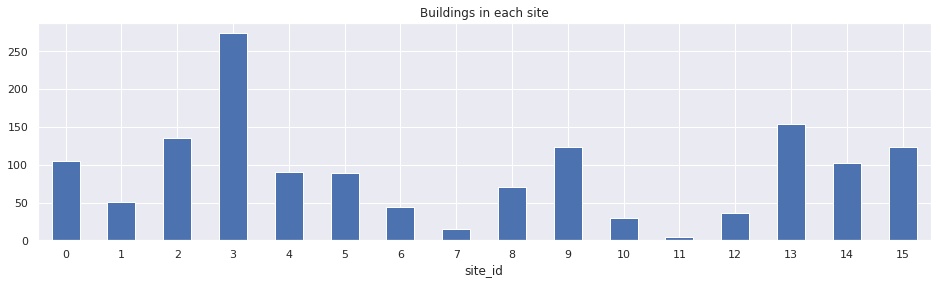

In [14]:
# Amount of buildings in each site
building.groupby('site_id').building_id.count().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Buildings in each site')

In [15]:
# Average values for each site
avg_bysite = building.groupby('site_id').mean().astype(int)[['square_feet', 'year_built', 'floor_count']]

# Total average values for all sites
avg_bysite.loc['All'] = avg_bysite.mean() 

avg_bysite

square_feet  year_built  floor_count
site_id                                      
0           86394.00      1995.0       3.0000
1           65002.00      1961.0       7.0000
2           99542.00      1974.0       3.0000
3           75290.00      1961.0       2.0000
4           92876.00      1954.0       5.0000
5           47612.00      1962.0       2.0000
6           91857.00      1966.0       3.0000
7          323634.00      1958.0       8.0000
8           29712.00      1964.0       1.0000
9          144874.00      1965.0       4.0000
10          71152.00      1965.0       2.0000
11         104563.00      1964.0       3.0000
12          79338.00      1966.0       2.0000
13         128342.00      1970.0       4.0000
14          95111.00      1969.0       3.0000
15          83921.00      1962.0       3.0000
All        101201.25      1966.0       3.4375

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

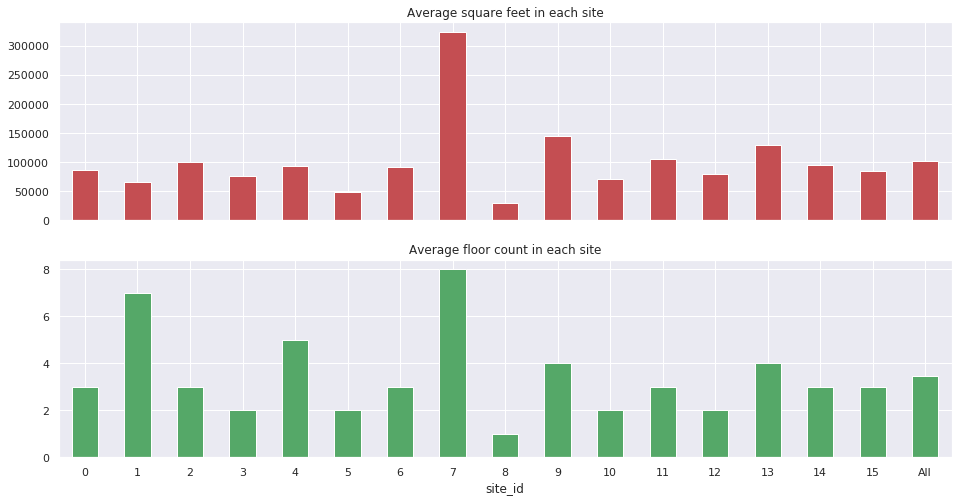

In [16]:
# Subplot titles
titles = ['Average %s in each site' % col for col in ['square feet', 'floor count']]

# Average square_feet and floor_count
avg_bysite.drop('year_built', axis=1).plot(kind='bar', subplots=True, figsize=(16, 8), title=titles, legend=False, color=['r', 'g'])
plt.xticks(rotation=0)

Text(0.5, 1.0, 'Average year built of buildings in each site')

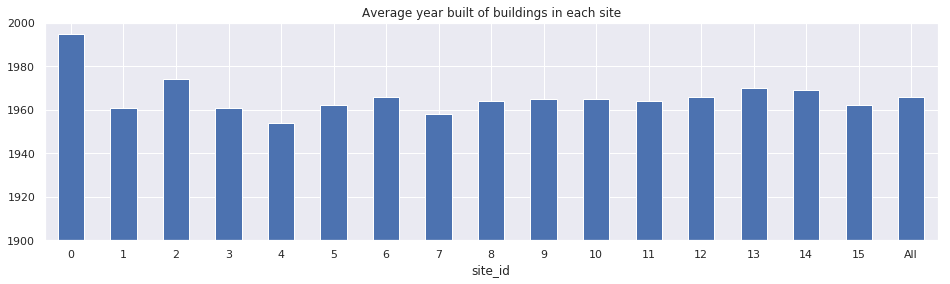

In [17]:
# Average year_built
avg_bysite.year_built.plot(kind='bar')
plt.ylim(1900, 2000)
plt.xticks(rotation=0)
plt.title('Average year built of buildings in each site')

Text(0.5, 1.0, 'Types of buildings')

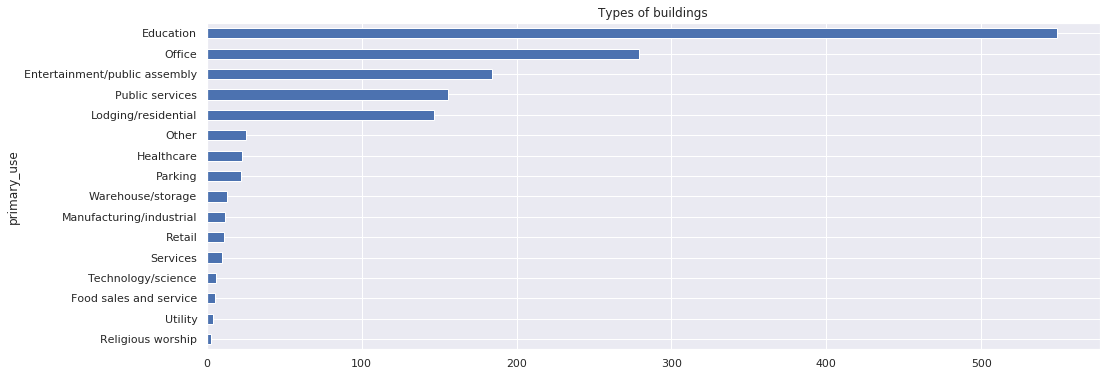

In [18]:
# Amount of buildings by type
use_ct = building.groupby('primary_use').building_id.count().sort_values()

use_ct.plot(kind='barh', figsize=(16, 6))
plt.title('Types of buildings')

In [19]:
# Amount of each type of building in each site
use_bysite = building.groupby(['site_id', 'primary_use']).building_id.count()
use_bysite = use_bysite.unstack('primary_use', 0)
use_bysite

primary_use  Education  Entertainment/public assembly  Food sales and service  \
site_id                                                                         
0                   30                              5                       0   
1                   22                              1                       0   
2                   61                             21                       2   
3                   92                             44                       0   
4                   66                              9                       0   
5                   49                             18                       0   
6                   15                              4                       0   
7                   15                              0                       0   
8                    0                             24                       0   
9                   63                             18                       0   
10                  14                              4                       0   
11                   5                              0                       0   
12                  20                              2                       0   
13                  25                              8                       1   
14                  26                             10                       2   
15                  46                             16                       0   

primary_use  Healthcare  Lodging/residential  Manufacturing/industrial  \
site_id                                                                  
0                     0                   27                         0   
1                     0                   10                         0   
2                     1                   12                         0   
3                     6                   11                         0   
4                     0                    4                         0   
5                     1                    1                         3   
6                     0                   12                         0   
7                     0                    0                         0   
8                     0                    0                         0   
9                     0                   19                         0   
10                    0                    3                         0   
11                    0                    0                         0   
12                    0                    0                         0   
13                    4                   10                         6   
14                   10                    9                         0   
15                    1                   29                         3   

primary_use  Office  Other  Parking  Public services  Religious worship  \
site_id                                                                   
0                24      5        8                0                  0   
1                16      0        0                2                  0   
2                24      0        3                6                  1   
3                23      4        1               86                  1   
4                 0      0        3                6                  0   
5                11      1        0                5                  0   
6                11      0        0                2                  0   
7                 0      0        0                0                  0   
8                 7      9        0               28                  0   
9                17      0        0                2                  0   
10                5      3        0                0                  0   
11                0      0        0                0                  0   
12                9      0        0                1                  0   
13               75      3        7                5                  0   
14      

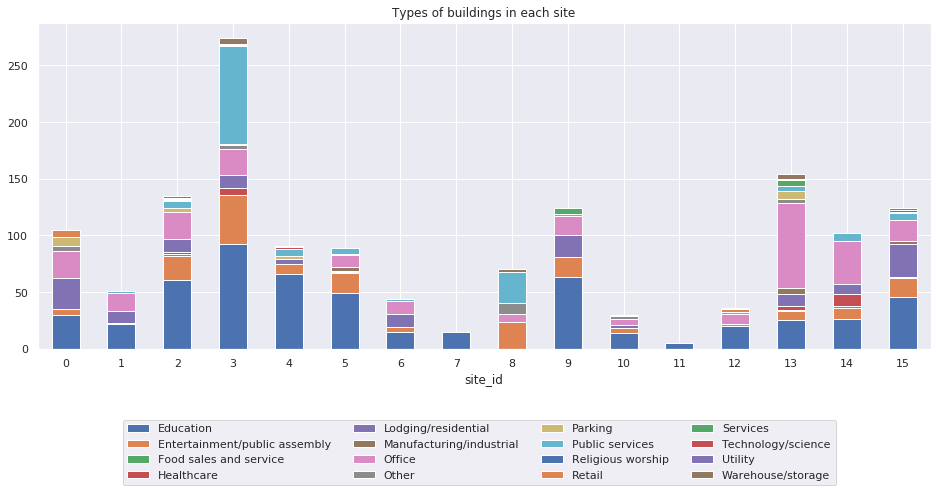

In [20]:
# Building type makeup of each site
use_bysite.plot(kind='bar', stacked=True, figsize=(16, 6))
plt.xticks(rotation=0)
plt.title('Types of buildings in each site')
plt.legend(bbox_to_anchor=(0.9, -0.2), ncol=4, fancybox=True)

In [21]:
del use_bysite, avg_bysite, titles, fig

Average `square_feet`, `floor_count`, and `year_built` by site:
- Site 3 has the most buildings so it has the most weight on the total
    - Half of the `year_built` values and all of the `floor_count` values in site 3 were originally missing
        - The missing `year_built` values were imputed with the median `year_built` of the corresponding type of building
        - The missing `floor_count` values were imputed based on the buildings' `square_feet` divided into 26 bins
- Site 7 has the largest buildings on average, both in terms of `square_feet` and `floor_count`
    - But it also has the 2nd least amount of buildings so there's actually less weight on this site
- Site 1 and site 4 also have taller buildings on average
- Most of the buildings in site 8 have only 1 floor
- Site 0 has a lot of newer buildings

Summary of `primary_use`:
- Education and office buildings make up more than half of the buildings
- Some, if not most, of these sites may be universities
    - Education buildings are a major portion of every site except site 8
- Sites 13 and 14 may be commercial areas since they contain a lot of office buildings
- Sites 3 and 8 have a lot of public services buildings

Note: These insights only reflect the buildings in the data.

##### Visualize the data by the type of building

In [22]:
# Average values for each building type
avg_byuse = building.groupby('primary_use').mean().astype(int)[['square_feet', 'year_built', 'floor_count']]

# Sort based on the amount of each building type present in the data
avg_byuse = avg_byuse.reindex(use_ct.index)

avg_byuse

square_feet  year_built  floor_count
primary_use                                                        
Religious worship                    11276        1974            1
Utility                              31095        1975            1
Food sales and service               38485        1992            1
Technology/science                   59176        1940            3
Services                            200659        1967            6
Retail                               39298        1992            1
Manufacturing/industrial             41120        1963            1
Warehouse/storage                    45584        1976            2
Parking                             279341        1997            8
Healthcare                          140480        1986            4
Other                                31456        1972            1
Lodging/residential                  85368        1970            3
Public services                      64947        1962            2
Entertainment/public assembly        80584        1966            3
Office                               87065        1970            3
Education                           104329        1963            4

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

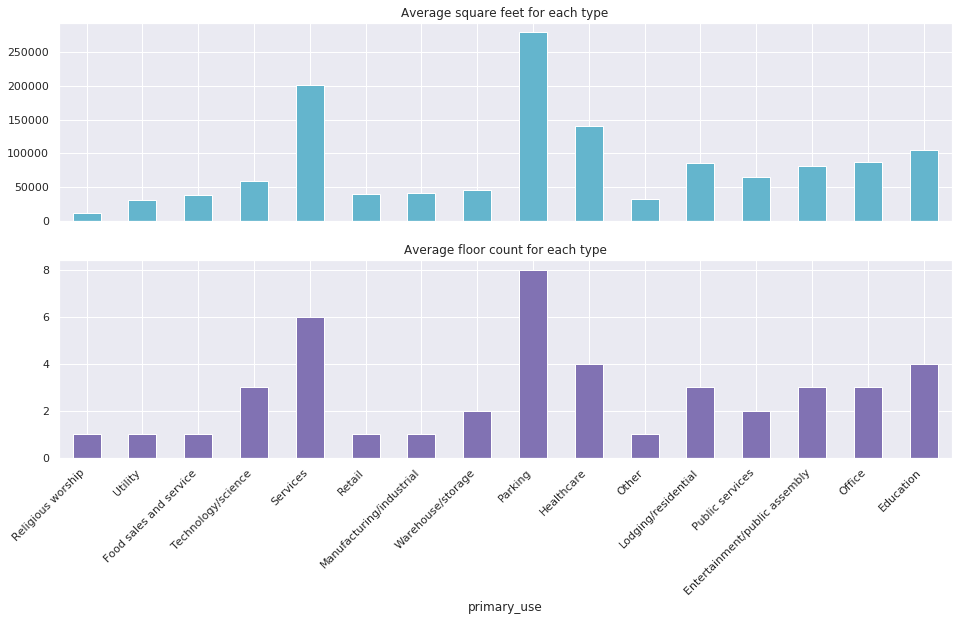

In [23]:
# Subplot titles
titles = ['Average %s for each type' % col for col in ['square feet', 'floor count']]

# Average square_feet and floor_count
avg_byuse[['square_feet', 'floor_count']].plot(kind='bar', subplots=True, figsize=(16, 8), title=titles, legend=False, color=['c', 'm'])
plt.xticks(rotation=45, ha='right')

Text(0.5, 1.0, 'Average year built of buildings for each type')

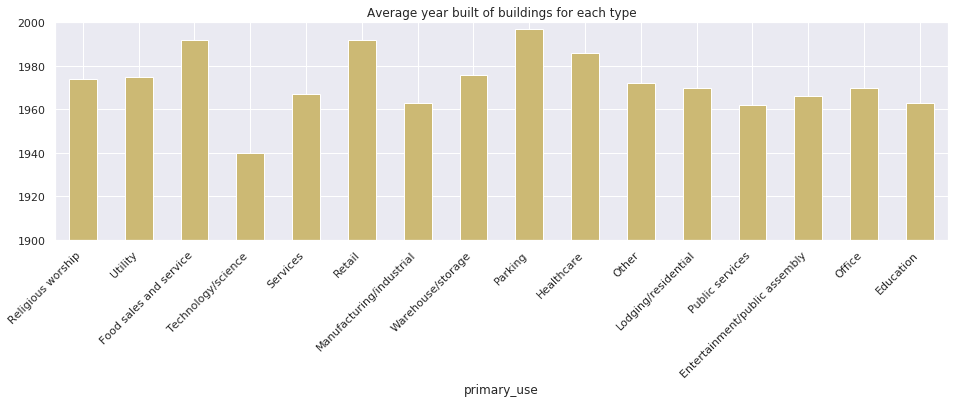

In [24]:
# Average year_built
avg_byuse.year_built.plot(kind='bar', figsize=(16, 4), color='y')
plt.ylim(1900, 2000)
plt.xticks(rotation=45, ha='right')
plt.title('Average year built of buildings for each type')

In [25]:
del use_ct, avg_byuse, titles

Average `square_feet`, `year_built`, and `floor_count` for each type of building:
- As education and office buildings populate more than half of the data, it's natural to see their averages line up with the total averages because they have more weight in contributing to the total averages
- The largest buildings on average (in terms of `square_feet` and `floor_count`) are parking structures, followed by service buildings then health care buildings
- On average, the tallest buildings are technology/science buildings, which are also the oldest buildings
- The newest buildings on average are retail, parking structures, and food sales/services

##### Check the distribution and outliers of the `square_feet` column

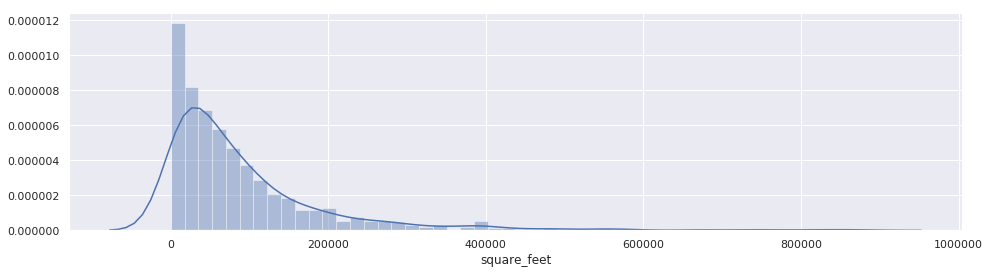

In [26]:
sns.distplot(building.square_feet)

In [27]:
# Use the mean + 3 standard deviations as a standard to filter for outliers
mean_3std = int(building.square_feet.mean() + (3 * building.square_feet.std()))

# Find outliers
building[building.square_feet > mean_3std].shape[0]

29

In [28]:
del mean_3std
gc.collect()

985

The `square_feet` values are very skewed to the right with about 29 outliers. The threshold for defining outliers here was anything larger than the mean plus 3 standard deviations, which in a normal distribution, contains 99.7% of the data.* Since a lot of the `year_built` and `floor_count` data was originally missing, plotting the distribution won't give any meaningful information because it wouldn't be an accurate representation of the real data.

Note: The `square_feet` data is not normally distributed. This outlier definition was an arbitrary choice.

<a id='eda_wthr'></a>
### Weather Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [29]:
weather.describe()

site_id  air_temperature  cloud_coverage  dew_temperature  \
count  140544.000000    140544.000000   140544.000000    140544.000000   
mean        7.500000        14.355564        2.474535         7.297695   
std         4.609789        10.669825        2.641932         9.824859   
min         0.000000       -28.900000        0.000000       -35.000000   
25%         3.750000         7.200000        0.000000         0.600000   
50%         7.500000        15.000000        2.000000         8.200000   
75%        11.250000        22.200001        4.000000        14.400000   
max        15.000000        47.200001        9.000000        26.100000   

       precip_depth_1_hr  sea_level_pressure  wind_direction     wind_speed  
count      140544.000000       140544.000000   140544.000000  140544.000000  
mean            2.406415         1016.132385      216.403888       3.559298  
std            13.364743            7.884603      104.689191       2.333769  
min             0.000000          968.200012       10.000000       0.000000  
25%             0.000000         1011.688110      130.000000       2.100000  
50%             0.000000         1016.400024      230.000000       3.100000  
75%             0.010000         1020.900024      310.000000       5.000000  
max           343.000000         1045.500000      360.000000      19.000000

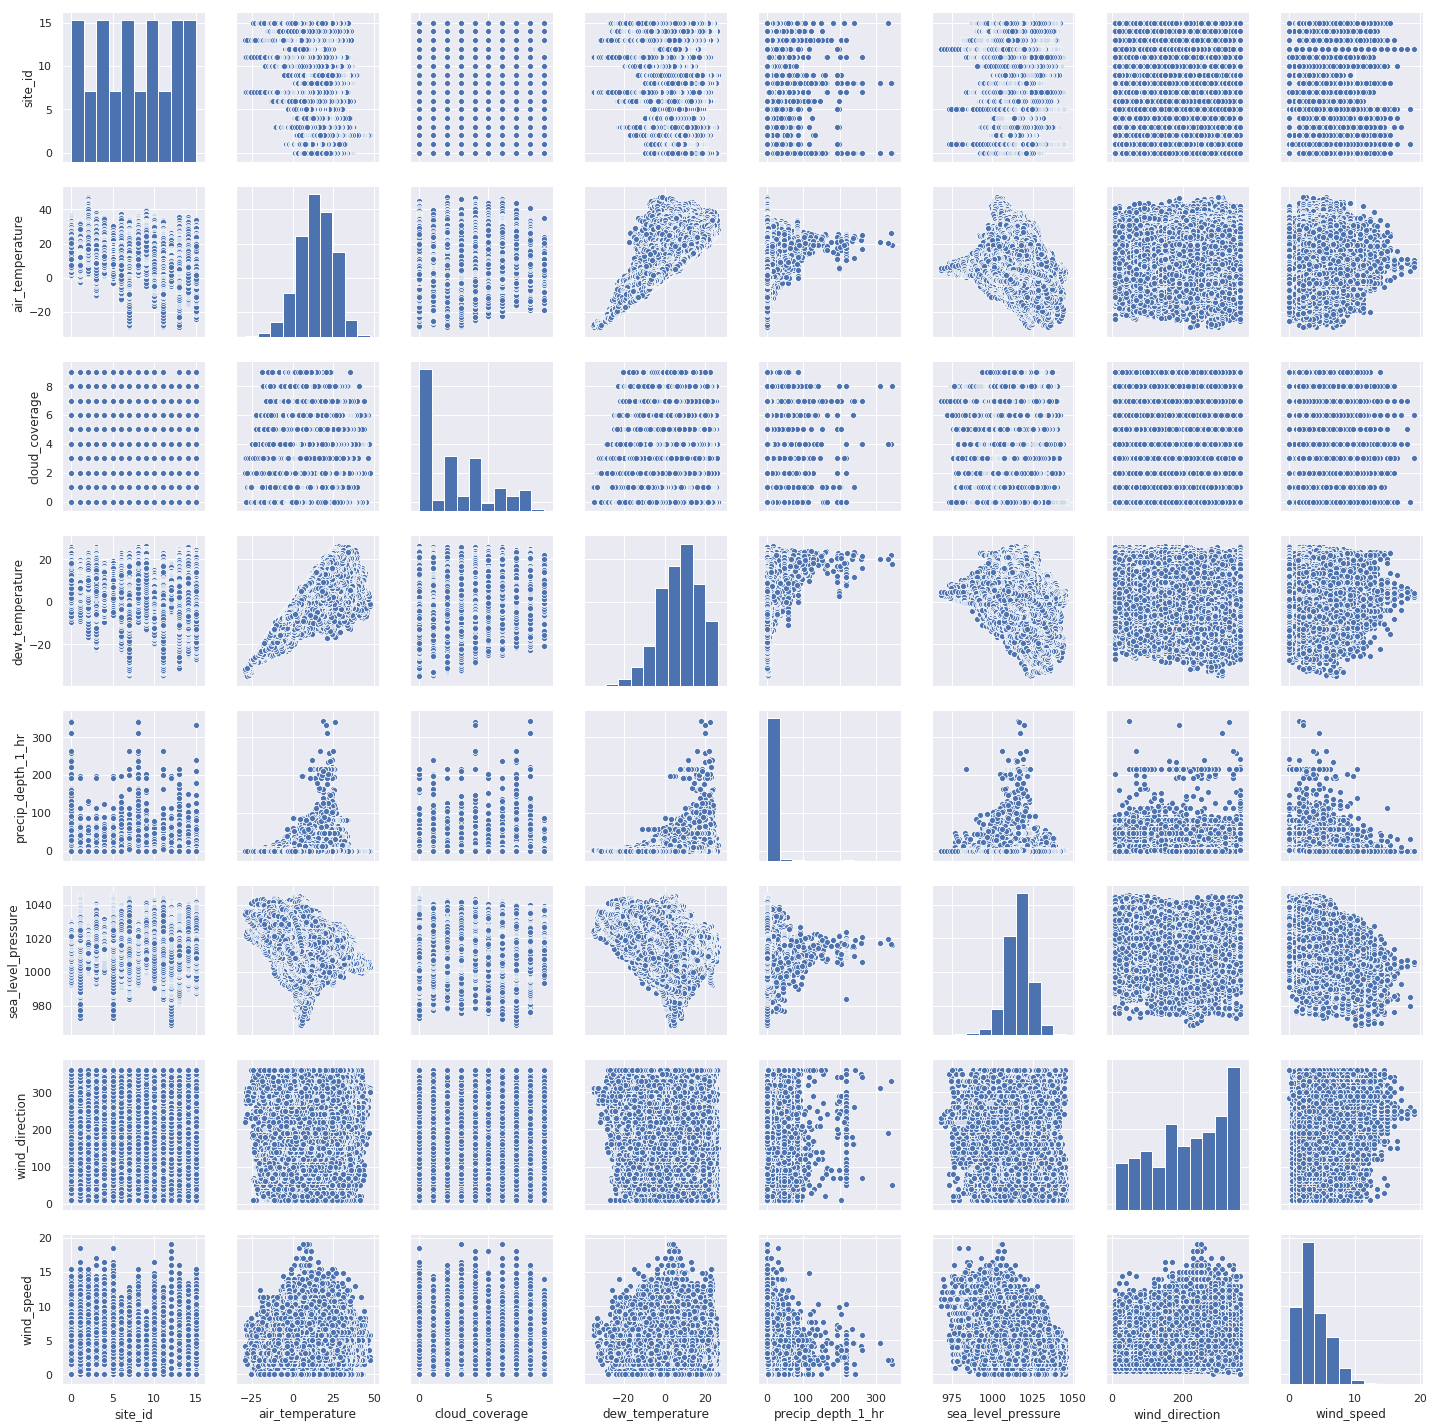

In [30]:
sns.pairplot(weather)

##### Visualize by site

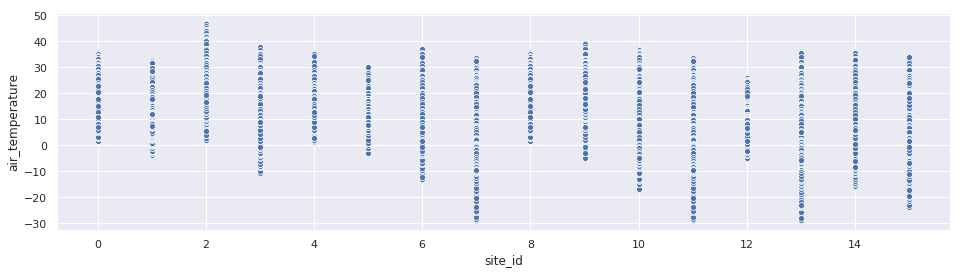

In [31]:
sns.scatterplot('site_id', 'air_temperature', data=weather)

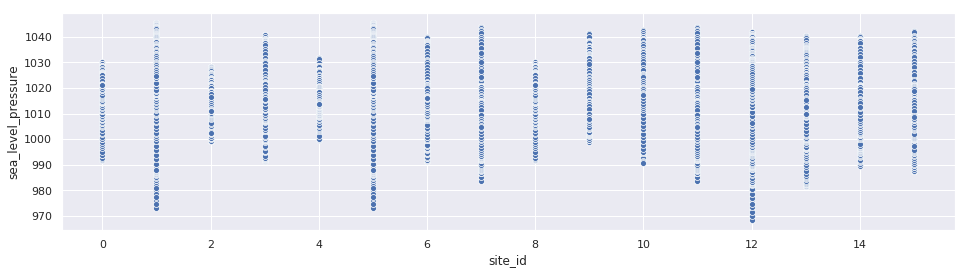

In [32]:
sns.scatterplot('site_id', 'sea_level_pressure', data=weather)

These plots support the following claims made during the cleaning process:
- Sites 1, 5, and 12 are near each other
- Sites 7, 11, and 15 are near each other in a colder region
    - Site 13 may also be near these 3 sites

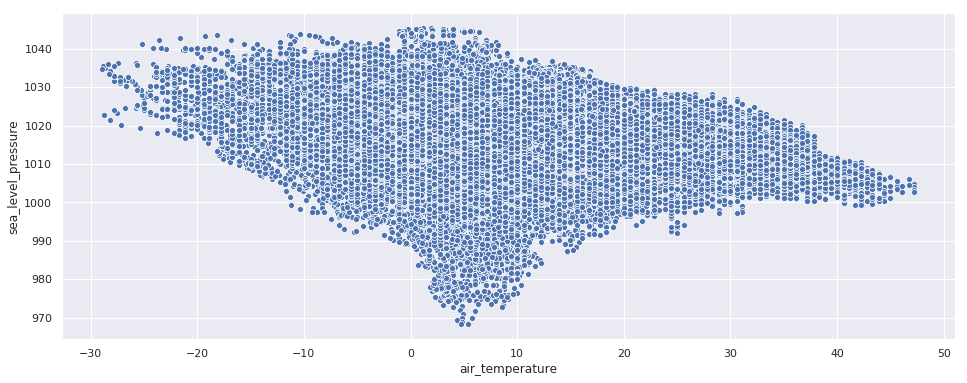

In [33]:
fig = plt.figure(figsize=(16, 6))
sns.scatterplot('air_temperature', 'sea_level_pressure', data=weather)

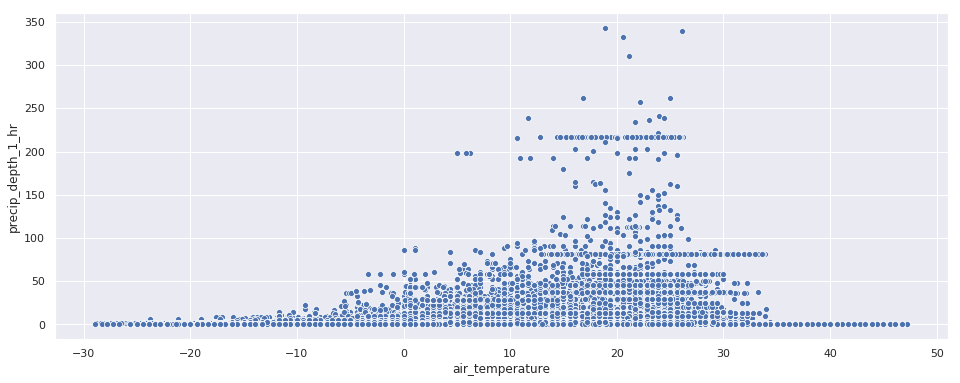

In [34]:
fig = plt.figure(figsize=(16, 6))
sns.scatterplot('air_temperature', 'precip_depth_1_hr', data=weather)

In [35]:
del fig

Observations:
- The highest and lowest `sea_level_pressure` both occur at an `air_temperature` of about 5 degrees Celsius
- The most rain occurs at `air_temperature`s of around 5 to 25 degrees Celsius

##### Time series analysis

In [36]:
# Extract 1 site and downsample to daily frequency
wthr0_day = weather[weather.site_id == 0].drop('site_id', axis=1).set_index('timestamp').resample('d').mean()
wthr0_day.head()

air_temperature  cloud_coverage  dew_temperature  \
timestamp                                                      
2016-01-01        23.337500        5.333333        20.020834   
2016-01-02        19.537500        6.041667        15.325000   
2016-01-03        14.829166        8.000000        12.479167   
2016-01-04        12.666667        4.458333         4.429167   
2016-01-05        14.058333        2.541667         7.066667   

            precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  
timestamp                                                                      
2016-01-01           0.002083         1018.960938      272.916667    1.854167  
2016-01-02           0.000833         1018.966187      167.500000    3.925000  
2016-01-03           0.794583         1017.241638      276.666667    5.000000  
2016-01-04           0.750833         1015.647461      318.333333    4.283333  
2016-01-05           0.000000         1022.370850      142.083333    6.258333

(array([16801, 16832, 16861, 16892, 16922, 16953, 16983, 17014, 17045,
        17075, 17106, 17136, 17166]), <a list of 13 Text xticklabel objects>)

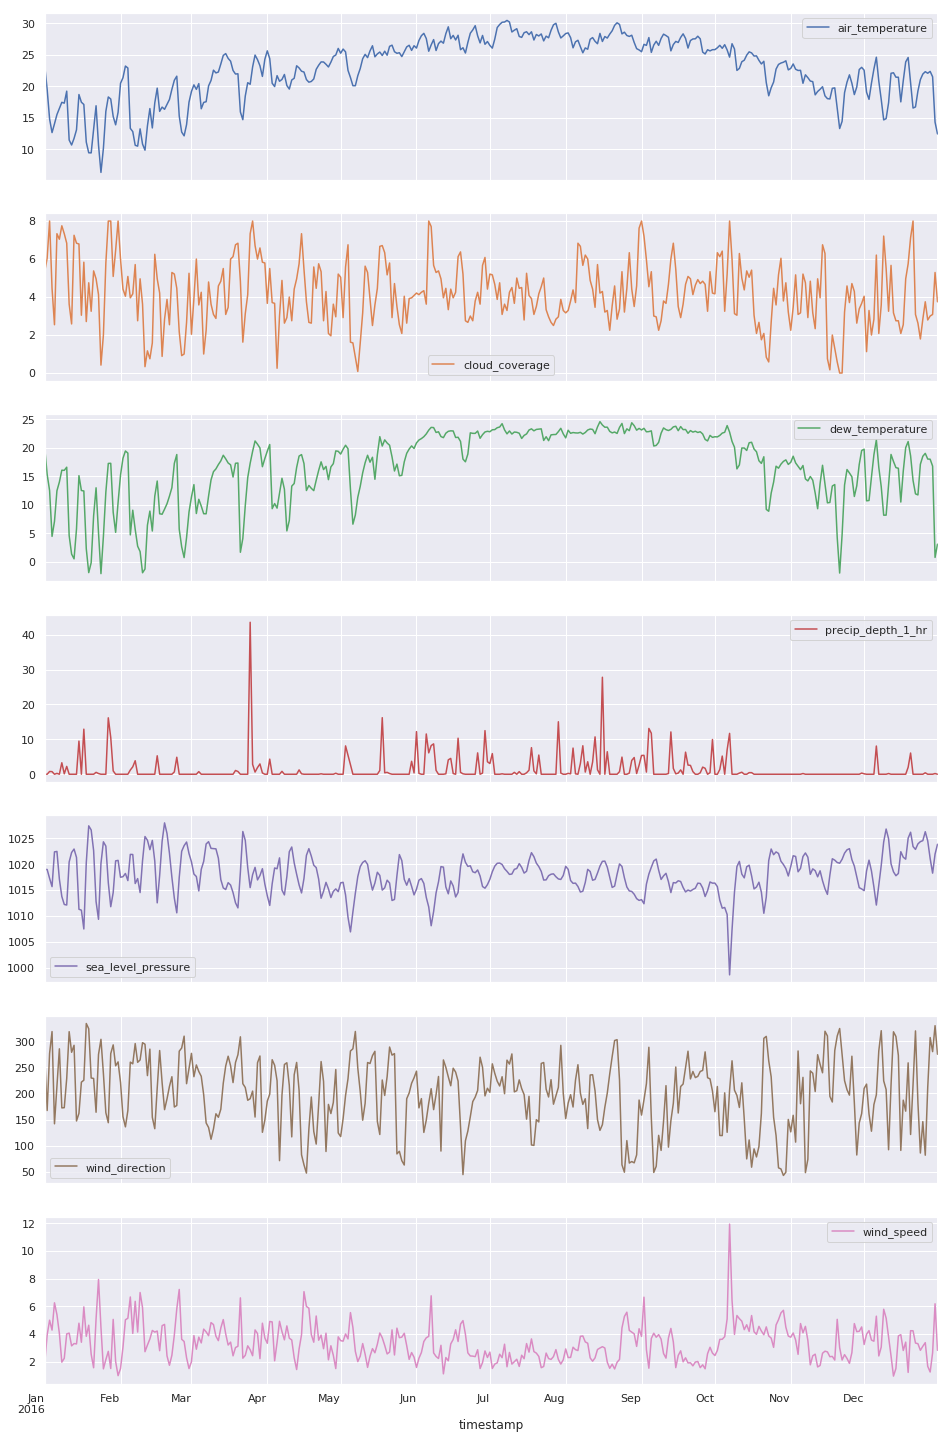

In [37]:
# Daily weather in site 0
wthr0_day.plot(subplots=True, figsize=(16, 28))
plt.xticks(rotation=0)

In [38]:
del wthr0_day

Observations:
- As expected, there is a rise in temperature around summertime
- The oscillations in `cloud_coverage` and `wind_direction` have a lower amplitude (wave height) during the summer months
- A lot of rain is seen at the end of March and in the middle of August
- The deepest dip in `sea_level_pressure` occurs at approximately the same time as the highest peak in `wind_speed`

In [39]:
# Extract hour from timestamp
weather['hour'] = weather.timestamp.dt.hour

# Site 4 hourly weather
wthr4 = weather[weather.site_id == 4].drop('site_id', axis=1)
wthr4_byhr = wthr4.groupby('hour').mean()

wthr4_byhr

air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
hour                                                                        
0           18.429235        2.587432        10.295629           0.376257   
1           17.559017        2.617486        10.228142           0.370847   
2           16.497814        2.587432        10.210110           0.324317   
3           15.537705        2.532787        10.153278           0.253197   
4           14.852733        2.461749        10.144262           0.275027   
5           14.421311        2.316940        10.099727           0.179426   
6           14.056830        2.240437        10.018306           0.182377   
7           13.726230        2.133880         9.959563           0.357158   
8           13.477595        2.054645         9.864481           0.280601   
9           13.225956        2.008197         9.719398           0.392650   
10          13.005737        2.071038         9.583607           0.114044   
11          12.836612        2.019126         9.484153           0.116776   
12          12.570765        2.087432         9.301366           0.103142   
13          12.376503        2.251366         9.248088           0.357131   
14          12.464208        2.366120         9.267487           0.373661   
15          12.968852        2.497268         9.444263           0.398388   
16          14.024863        2.543716         9.832139           0.365383   
17          15.154371        2.546448        10.150546           0.212404   
18          16.210655        2.500000        10.147541           0.168716   
19          17.238525        2.456284        10.051879           0.272459   
20          18.124863        2.409836         9.994263           0.070246   
21          18.772678        2.475410        10.024317           0.258716   
22          19.107103        2.521858        10.073771           0.215137   
23          19.016666        2.565574        10.167486           0.234180   

      sea_level_pressure  wind_direction  wind_speed  
hour                                                  
0            1016.129333      266.748634    5.947268  
1            1016.019714      266.188525    5.579782  
2            1016.091248      267.745902    5.095082  
3            1016.290588      265.491803    4.547267  
4            1016.573486      269.316940    4.071858  
5            1016.859009      267.745902    3.654645  
6            1016.994934      263.852459    3.403005  
7            1016.981750      260.983607    3.117213  
8            1016.929382      255.136612    3.054372  
9            1016.787415      242.841530    3.013934  
10           1016.684998      243.633880    2.960929  
11           1016.601562      239.565574    2.848361  
12           1016.558044      228.207650    2.635519  
13           1016.686462      218.286885    2.616120  
14           1016.958679      228.784153    2.683060  
15           1017.301270      234.467213    2.657650  
16           1017.619629      241.229508    2.749454  
17           1017.851440      234.781421    3.201366  
18           1017.991394      232.404372    3.548361  
19           1017.897095      243.784153    3.891257  
20           1017.478088      252.459016    4.604918  
21           1016.975708      257.322404    5.186066  
22           1016.556580      262.786885    5.649454  
23           1016.272949      263.374317    5.878415

([<matplotlib.axis.XTick at 0x7f1a0a556eb8>,
 <a list of 24 Text xticklabel objects>)

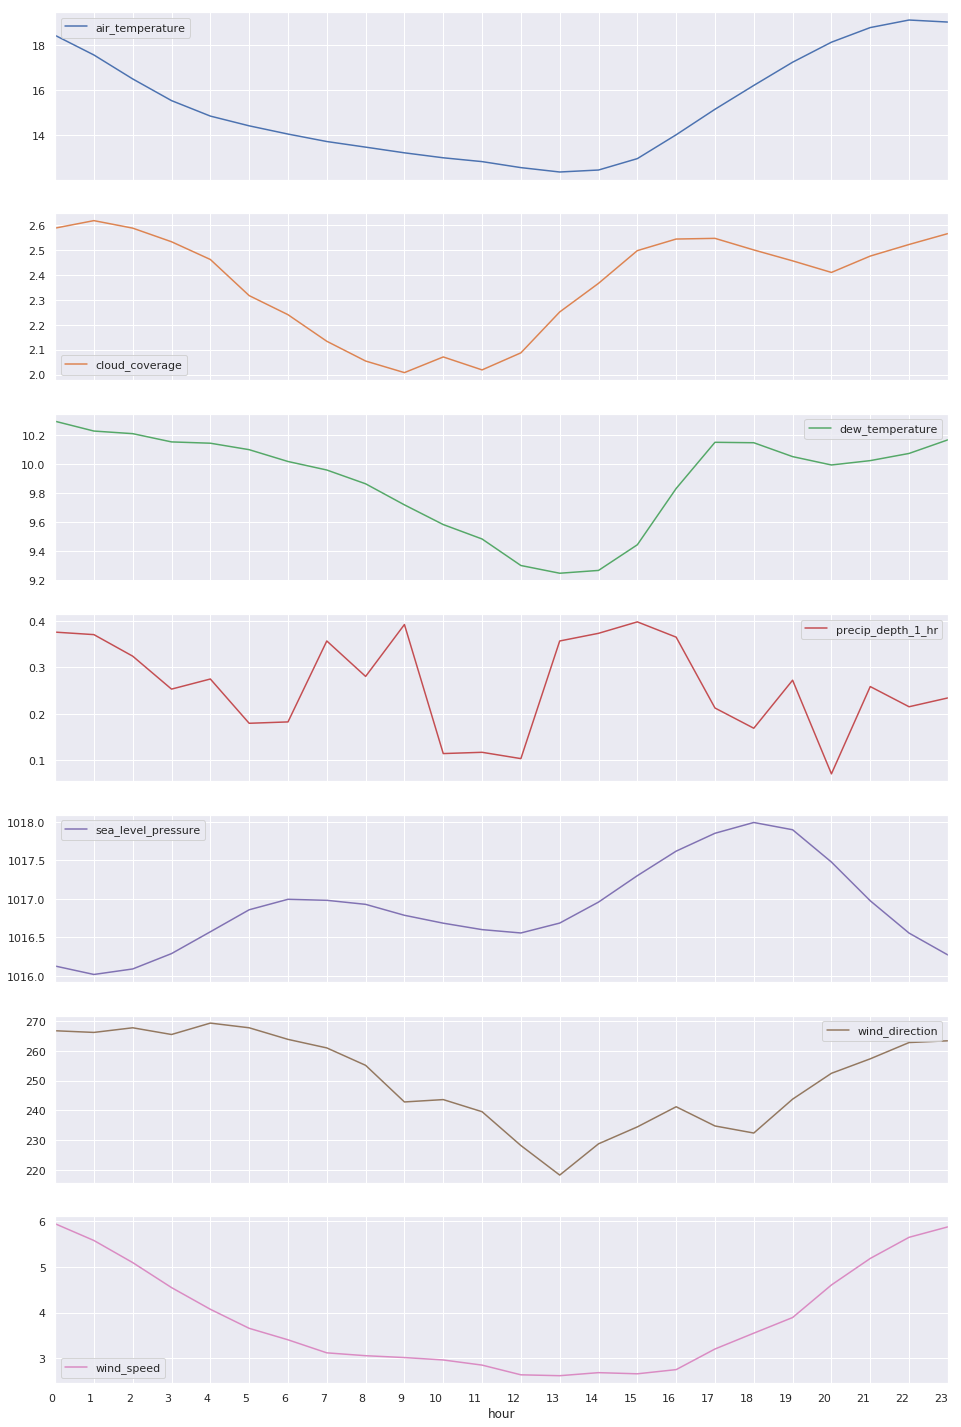

In [40]:
# Hourly weather of site 4 averaged across everyday in 2016
wthr4_byhr.plot(subplots=True, figsize=(16,28))
plt.xticks(range(24), rotation=0)

The temperature here doesn't look quite right. According to the `air_temperature` subplot, the temperature at this site is at the daily high at around 10 PM. There may be an error with the data.

##### Check the average hourly `air_temperature` at every site

In [41]:
# Average hourly air temperature by site
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp

site_id         0          1          2          3          4          5   \
hour                                                                        
0        23.481148  10.001579  30.238525  16.589077  18.429235   9.669505   
1        22.490711   9.690836  29.461203  15.855423  17.559017   9.498009   
2        21.805464   9.438734  28.376053  15.239617  16.497814   9.357673   
3        21.277596   9.190984  27.166666  14.760608  15.537705   9.227823   
4        20.880054   9.017213  26.021038  14.364207  14.852733   9.100926   
5        20.408743   9.005191  24.926777  13.959352  14.421311   9.078324   
6        20.083059   9.263934  23.953552  13.655741  14.056830   9.201248   
7        19.730328   9.804645  23.201094  13.265697  13.726230   9.571202   
8        19.445263  10.562518  22.425957  12.994809  13.477595  10.093286   
9        19.265450  11.518579  21.620218  12.686066  13.225956  10.786885   
10       19.094851  12.520219  20.950274  12.393716  13.005737  11.510929   
11       19.113115  13.400620  20.350821  12.455738  12.836612  12.097160   
12       19.631695  14.103064  19.831694  12.917213  12.570765  12.565810   
13       21.205465  14.506161  19.415028  13.796994  12.376503  12.931075   
14       23.064207  14.849725  19.621311  14.863388  12.464208  13.081967   
15       24.689344  14.761679  20.757103  16.008196  12.968852  13.016086   
16       25.924591  14.430512  22.664480  17.064482  14.024863  12.740669   
17       26.713934  13.897540  24.577595  18.035519  15.154371  12.341593   
18       27.208197  13.310298  26.236612  18.787704  16.210655  11.854065   
19       27.518579  12.635965  27.619398  19.104372  17.238525  11.338405   
20       27.324043  12.026411  28.775682  19.199682  18.124863  10.789851   
21       26.818033  11.472677  29.677103  18.942034  18.772678  10.421255   
22       26.032515  10.980328  30.246449  18.249180  19.107103  10.196721   
23       24.760656  10.432116  30.457376  17.451639  19.016666   9.959180   

site_id         6          7          8          9          10         11  \
hour                                                                        
0        16.328962   9.239038  23.481148  24.332787  15.720219   9.239038   
1        15.329782   8.289638  22.490711  23.072620  14.725683   8.289638   
2        14.601912   7.553571  21.805464  21.981222  13.554645   7.553571   
3        13.974317   6.997800  21.277596  21.131147  12.117535   6.997800   
4        13.442349   6.476724  20.880054  20.340630  11.005112   6.476724   
5        13.037978   6.013010  20.408743  19.635519  10.353354   6.013010   
6        12.551912   5.619685  20.083059  19.121038   9.833760   5.619685   
7        12.207707   5.200534  19.730328  18.687979   9.360452   5.200534   
8        11.886603   4.802525  19.445263  18.307924   8.954655   4.802525   
9        11.601316   4.461576  19.265450  17.986612   8.584316   4.461576   
10       11.265932   4.225305  19.094851  17.731968   8.189239   4.225305   
11       11.200684   4.581613  19.113115  17.533607   7.815240   4.581613   
12       11.734354   5.306109  19.631695  17.354372   7.463052   5.306109   
13       13.000000   6.118958  21.205465  17.499454   7.320840   6.118958   
14       14.627758   7.141798  23.064207  18.521585   8.018605   7.141798   
15       16.134378   8.220030  24.689344  20.142897   9.376229   8.220030   
16       17.419399   9.170306  25.924591  21.760109  11.077377   9.170306   
17       18.366667   9.953102  26.713934  23.283607  12.718033   9.953102   
18       19.145796  10.603958  27.208197  24.468330  14.056284  10.603958   
19       19.623224  10.998811  27.518579  25.453005  15.004800  10.998811   
20       19.776554  11.150941  27.324043  26.143089  15.646995  11.150941   
21       19.538927  11.144646  26.818033  26.395901  16.086338  11.144646   
22       18.724318  10.739876  26.032515  26.263231  16.366940  10.739876   
23       17.614754  10.048343  24.760656  25.557104  16.327362  10.04834

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a0a2814e0>,
      dtype=object)

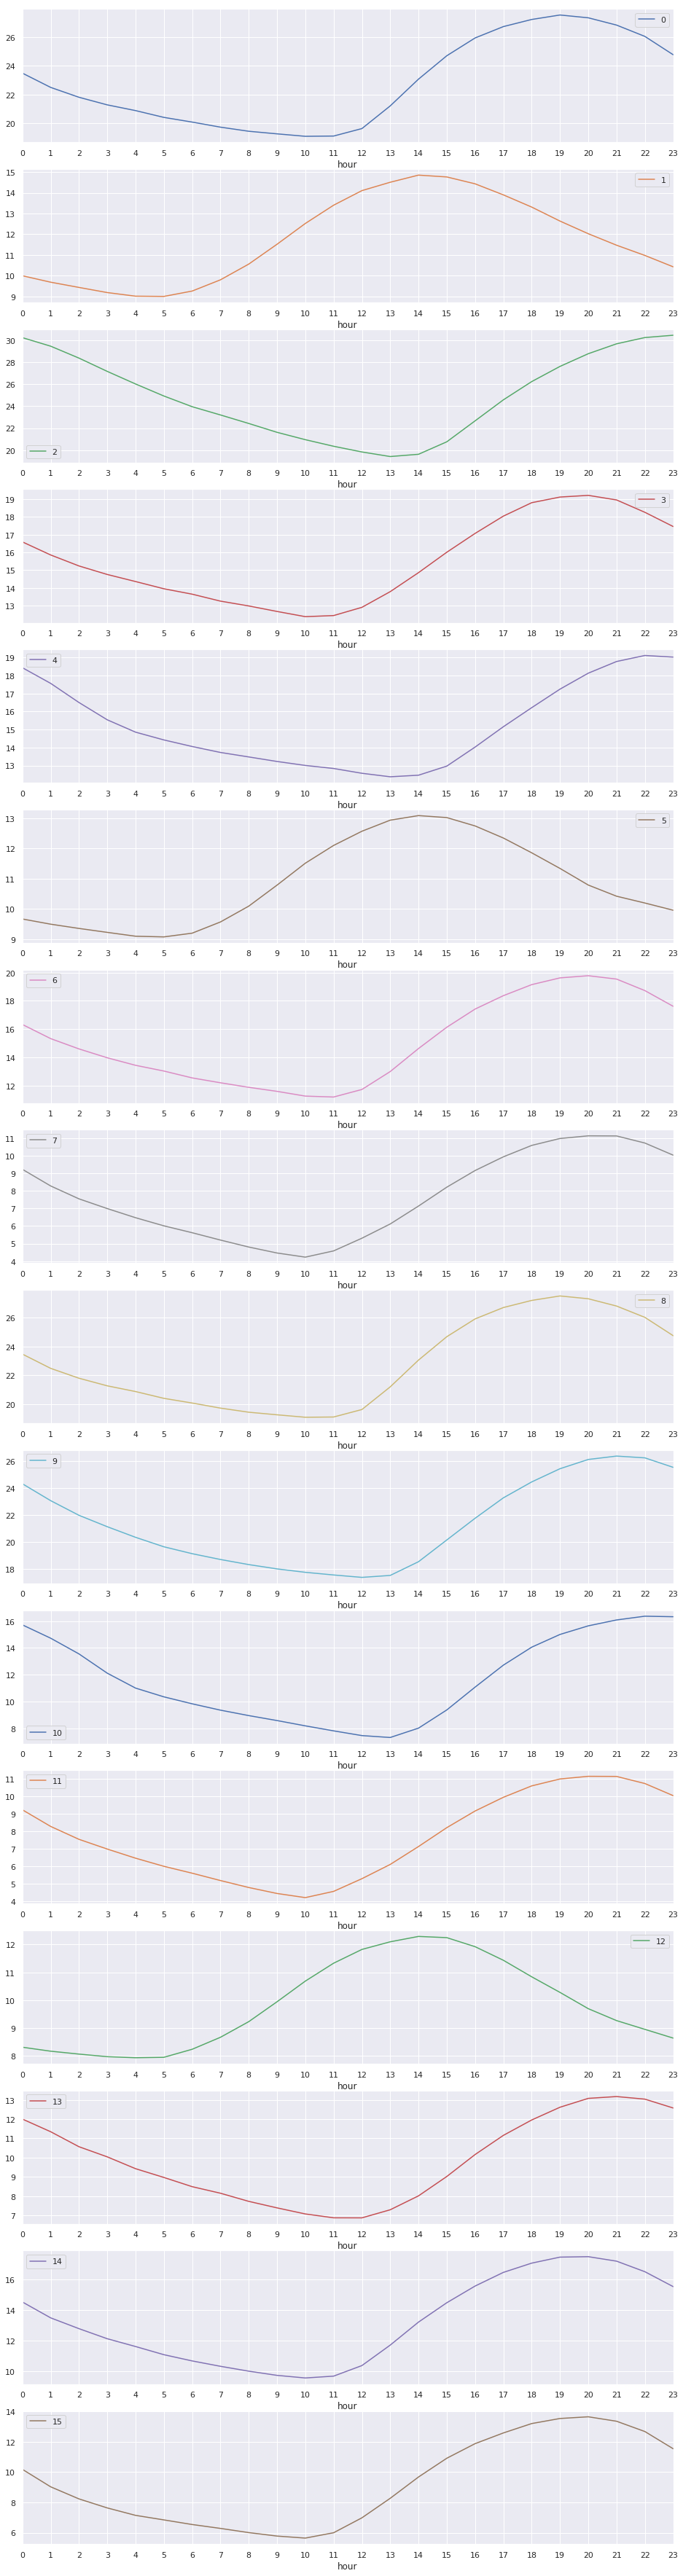

In [42]:
airtemp.plot(subplots=True, figsize=(16, 64), sharex=False, xticks=range(24))

This is not right at all. In many of the sites, the temperature is reaching its peak at night time hours and found at the daily low at morning to afternoon hours. This means the timestamps were most likely recorded in UTC (GMT).

This makes the problem more complicated but it does give some information. It supports the earlier claims that sites 1, 5, and 12 are nearby as they are in the same time zone. There is also support for sites 7, 11, and 15 also being in the nearby. Many other sites look like they are in the same time zone as sites 7, 11, and 15 too, so they may also be nearby. These claims are not definitive but there is a lot of information to support them.

In order to make better sense of the weather data, these timestamps will have to be converted to local time.

Thanks to the work of several Kagglers, most of the sites have been identified. The exact location of some of the sites are uncertain but the location has been narrowed down enough to determine the timezone for all sites. The locations and timezone of each site are as follows:
0. Orlando, Florida (GMT-5)
1. United Kingdom (GMT+0)
2. Arizona (GMT-7)
3. U.S. Eastern Time Zone (GMT-5)
4. Northern California (GMT-8)
5. United Kingdom (GMT+0)
6. U.S. Eastern Time Zone (GMT-5)
7. Southeastern Canada (GMT-5)
8. Orlando, Florida (GMT-5)
9. Texas (GMT-6)
10. U.S. Mountain Time Zone (GMT-7)
11. Southeastern Canada (GMT-5)
12. Dublin, Ireland (GMT+0)
13. Minnesota (GMT-6)
14. U.S. Eastern Time Zone (GMT-5)
15. U.S. Eastern Time Zone (GMT-5)

All the credit goes to Kaggle users: `poedator`, `patrick0302`, and `datadugong`.

Sources:
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698
- https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
- https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

##### Convert all the timestamps to local time

In [43]:
# List of timezone offsets for each site
timezone = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

# Offsets based on site
offset = weather.site_id.apply(lambda s: pd.offsets.Hour(timezone[s]))

# Adjust the timestamps and hours
weather.timestamp += offset
weather['hour'] = weather.timestamp.dt.hour

weather.head()

/home/tri/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1151: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2015-12-31 19:00:00        25.000000               6   
1        0 2015-12-31 20:00:00        24.400000               4   
2        0 2015-12-31 21:00:00        22.799999               2   
3        0 2015-12-31 22:00:00        21.100000               2   
4        0 2015-12-31 23:00:00        20.000000               2   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0               0.01         1019.700012             360   
1             21.1               0.01         1020.200012              70   
2             21.1               0.00         1020.200012             360   
3             20.6               0.00         1020.099976             360   
4             20.0               0.01         1020.000000             250   

   wind_speed  hour  
0         0.0    19  
1         1.5    20  
2         0.0    21  
3         0.0    22  
4         2.6    23

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a0a3360f0>,
      dtype=object)

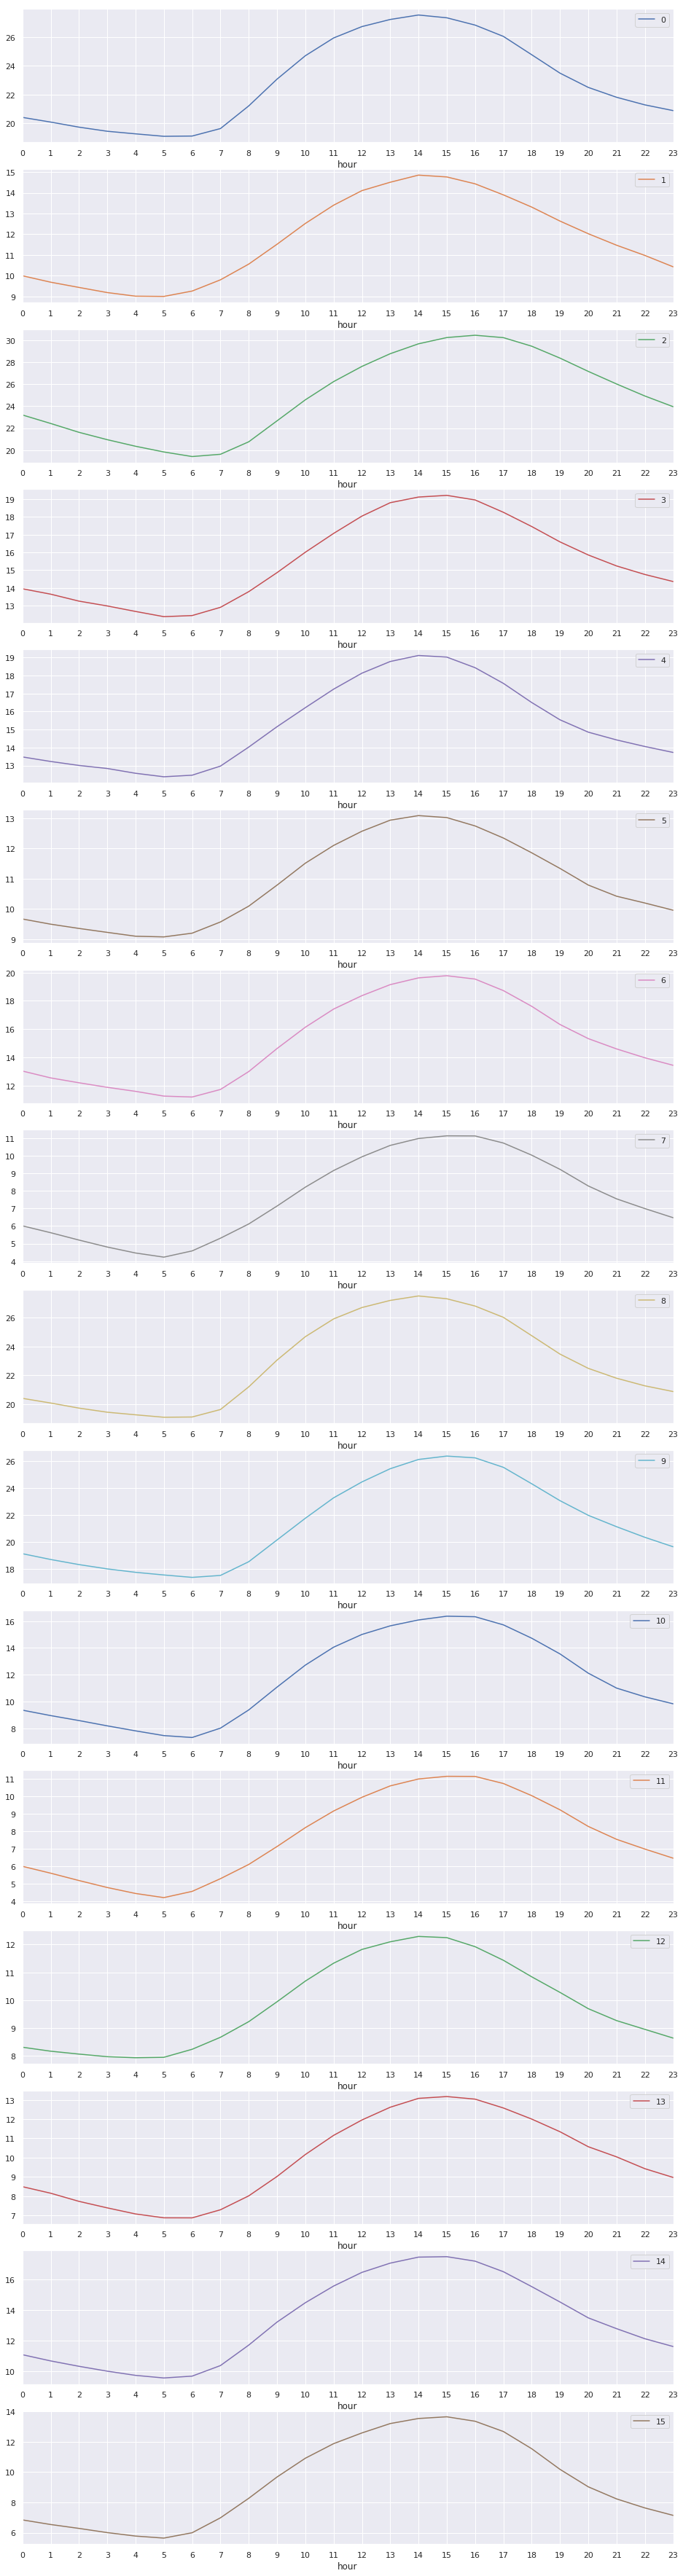

In [44]:
# Replot average hourly air temperature by site
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp.plot(subplots=True, figsize=(16, 64), sharex=False, xticks=range(24))

Now the temperature data makes a lot more sense. They don't line up exactly but that may be because the temperature peaks at different times at each location.

Due to this offset, the data now contains a few hours from 2015 and is missing a few hours at the end of 2016 at most sites.

##### Reindex the weather data to include every hour in 2016 and use forward fill to fill the data for the missing hours

In [45]:
weather.set_index(['site_id', 'timestamp'], inplace=True)

weather = weather.reindex(
    pd.MultiIndex.from_product([
        building.site_id.unique(), 
        pd.date_range(start='1/1/2016 00:00:00', end='12/31/2016 23:00:00', freq='H')
    ])
)

weather.index.rename(['site_id', 'timestamp'], inplace=True)
weather.reset_index(inplace=True)

weather.head()

site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2016-01-01 00:00:00             19.4             4.0   
1        0 2016-01-01 01:00:00             21.1             6.0   
2        0 2016-01-01 02:00:00             21.1             6.0   
3        0 2016-01-01 03:00:00             20.6             6.0   
4        0 2016-01-01 04:00:00             21.1             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             19.4               0.00         1019.762939           360.0   
1             21.1               0.01         1019.400024           360.0   
2             21.1               0.00         1018.799988           210.0   
3             20.0               0.00         1018.099976           360.0   
4             20.6               0.00         1019.000000           290.0   

   wind_speed  hour  
0         0.0   0.0  
1         0.0   1.0  
2         1.5   2.0  
3         0.0   3.0  
4         1.5   4.0

In [46]:
weather['hour'] = weather.timestamp.dt.hour
weather = weather.fillna(method='ffill')
weather.tail(10)

site_id           timestamp  air_temperature  cloud_coverage  \
140534       15 2016-12-31 14:00:00              3.0             1.0   
140535       15 2016-12-31 15:00:00              2.8             2.0   
140536       15 2016-12-31 16:00:00              2.8             2.0   
140537       15 2016-12-31 17:00:00              2.2             2.0   
140538       15 2016-12-31 18:00:00              1.7             2.0   
140539       15 2016-12-31 19:00:00              1.7             2.0   
140540       15 2016-12-31 20:00:00              1.7             2.0   
140541       15 2016-12-31 21:00:00              1.7             2.0   
140542       15 2016-12-31 22:00:00              1.7             2.0   
140543       15 2016-12-31 23:00:00              1.7             2.0   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
140534             -8.0               0.01         1007.320374   
140535             -8.9               0.01         1007.400024   
140536             -7.2               0.01         1007.500000   
140537             -6.7               0.01         1008.000000   
140538             -5.6               0.01         1008.500000   
140539             -5.6               0.01         1008.500000   
140540             -5.6               0.01         1008.500000   
140541             -5.6               0.01         1008.500000   
140542             -5.6               0.01         1008.500000   
140543             -5.6               0.01         1008.500000   

        wind_direction  wind_speed  hour  
140534           180.0         5.7    14  
140535           180.0         7.7    15  
140536           180.0         5.1    16  
140537           170.0         4.6    17  
140538           180.0         8.8    18  
140539           180.0         8.8    19  
140540           180.0         8.8    20  
140541           180.0         8.8    21  
140542           180.0         8.8    22  
140543           180.0         8.8    23

In [47]:
del airtemp, timezone, offset, wthr4, wthr4_byhr

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a0a34e160>,
      dtype=object)

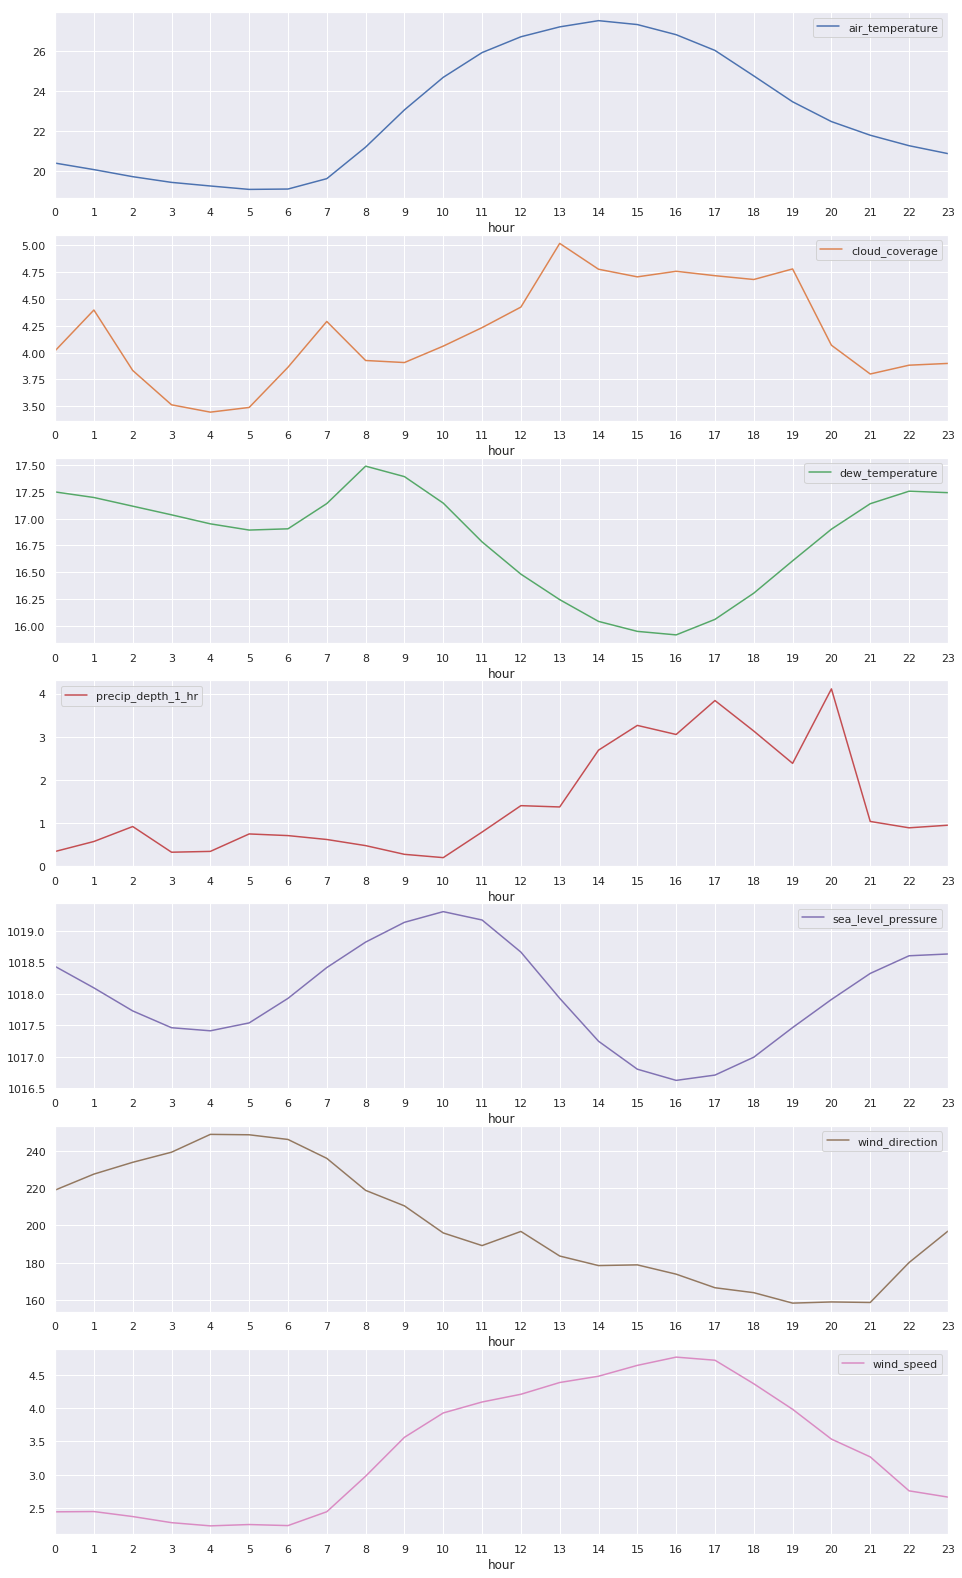

In [48]:
# Site 8 hourly weather
wthr8 = weather[weather.site_id == 8].drop('site_id', axis=1)
wthr8_byhr = wthr8.groupby('hour').mean()

# Hourly weather of site 8 averaged across everyday in 2016
wthr8_byhr.plot(subplots=True, figsize=(16,28), sharex=False, xticks=range(24))

In [49]:
del wthr8, wthr8_byhr

In site 8 (on average):
- The `air_temperature` peaks at 2 PM (in the afternoon as it should)
- The `cloud_coverage` is highest between 1 and 7 PM
- The `dew_temperature` dips in the afternoon to evening, which makes sense because it is less humid during these hours
- On rainy days, it rains the most between 5 and 8 PM
- The `sea_level_pressure` oscillates throughout the day reaching its maximum at 10 AM and minimum at 4 PM
- The `wind_direction` is limited between 160 and 250 degrees, which is roughly in the south to southwest direction
- It gets the windiest around 4 PM

<a id='eda_meter'></a>
### Meter Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [50]:
meter.describe()

building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   1.988706e+03
std    4.269133e+02  9.309921e-01   1.532159e+05
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.930000e+02  0.000000e+00   1.830000e+01
50%    8.950000e+02  0.000000e+00   7.877500e+01
75%    1.179000e+03  1.000000e+00   2.679840e+02
max    1.448000e+03  3.000000e+00   2.190470e+07

Although it was established that timestamps for every hour in 2016 are present in the meter data, some buildings have more meters than others so these buildings would have more timestamps. Some buildings may also be missing timestamps.

##### Check the amount of meter readings for each building

Text(0, 0.5, 'Number of meter readings')

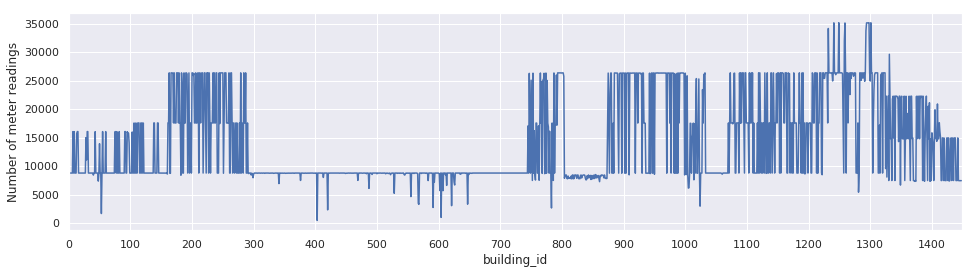

In [51]:
# Number meter readings each building has
meter.groupby('building_id').timestamp.count().plot()
plt.xticks(range(0, 1500, 100))
plt.ylabel('Number of meter readings')

Text(0, 0.5, 'Number of meters')

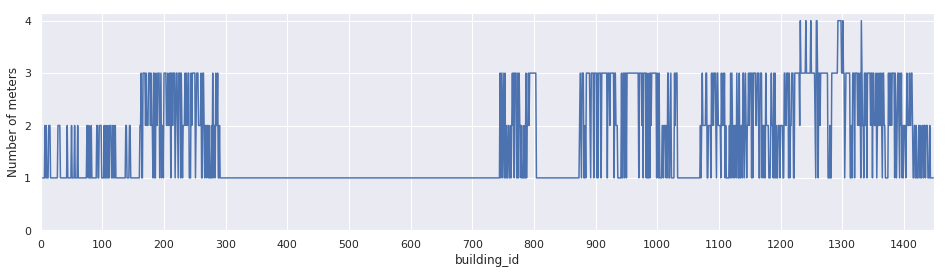

In [52]:
# Number of meters each building has
metrct = meter.groupby('building_id').meter.nunique()

metrct.plot()
plt.xticks(range(0, 1500, 100))
plt.yticks(range(5))
plt.ylabel('Number of meters')

Text(0, 0.5, 'Number of meters')

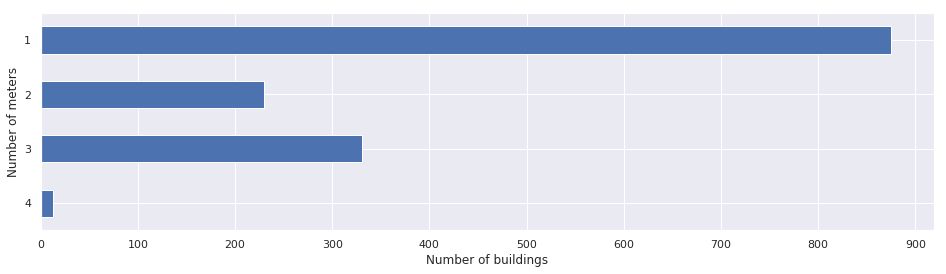

In [53]:
# Number of buildings that have n amount of meters
metrct.value_counts().sort_index(ascending=False).plot(kind='barh')
plt.xticks(range(0, 1000, 100))
plt.xlabel('Number of buildings')
plt.ylabel('Number of meters')

Text(0.5, 0, 'Number of buildings')

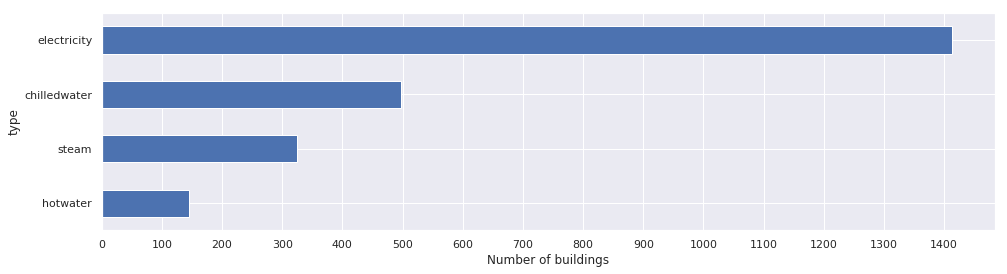

In [54]:
# Number of buildings that have each meter type
bldgct_bymetr = meter.groupby('type').building_id.nunique().sort_values()
bldgct_bymetr.plot(kind='barh')
plt.yticks(range(4))
plt.xticks(range(0, 1500, 100))
plt.xlabel('Number of buildings')

In [55]:
del metrct, bldgct_bymetr

Takeaways:
- Most of the buildings only have 1 type of meter and very few buildings actually have all 4 meter types
- Almost all the buildings have an electricity meter
- A lot of buildings don't have meter readings for every hour

##### Check the number of meters missing measurements

In [56]:
bybldgmetr = meter.groupby(['building_id', 'meter']).count().reset_index()
metrct = bybldgmetr.meter.value_counts()
types = ['electricity', 'chilledwater', 'steam', 'hotwater']

# Missing meter readings
metrs_m = bybldgmetr[bybldgmetr.timestamp != 8784]
bldgs_m = metrs_m.building_id.nunique()
types_m = metrs_m.meter.value_counts()

print(f'A total of {metrs_m.shape[0]} meters ({metrs_m.shape[0] * 100 // bybldgmetr.shape[0]}%) are missing meter readings')
print(f'{bldgs_m} different buildings ({bldgs_m * 100 // bybldgmetr.building_id.nunique()}%) have meters that are missing meter readings\n')

for i in range(types_m.shape[0]):
    print(f'{types_m[i]} {types[i]} meters ({types_m[i] * 100 // metrct[i]}%) are missing meter readings')

A total of 1660 meters (69%) are missing meter readings
1085 different buildings (74%) have meters that are missing meter readings

990 electricity meters (70%) are missing meter readings
347 chilledwater meters (69%) are missing meter readings
221 steam meters (68%) are missing meter readings
102 hotwater meters (70%) are missing meter readings


In [57]:
del bybldgmetr, metrct, types, metrs_m, bldgs_m, types_m, i

Every meter should have 8784 recorded readings (24 hours x 366 days). The majority of meters is actually missing meter readings. This may not be a problem since there are about 20 million records in the meter data. For now, the meter data will be left as is, but this is something important to note.

##### Time series analysis

In [58]:
bytime = meter.set_index('timestamp')
bytime.head()

building_id  meter  meter_reading         type
timestamp                                                 
2016-01-01            0      0            0.0  electricity
2016-01-01            1      0            0.0  electricity
2016-01-01            2      0            0.0  electricity
2016-01-01            3      0            0.0  electricity
2016-01-01            4      0            0.0  electricity

In [59]:
# Buildings that opened in 2016 and 2017
construct = building[building.in_construction == True]
construct

site_id  building_id                    primary_use  square_feet  \
28         0           28                         Office        52957   
45         0           45                         Retail        15304   
46         0           46                         Retail         9045   
99         0           99                         Office         2260   
103        0          103                      Education        21657   
363        3          363                      Education        69300   
409        3          409                      Education        38500   
567        4          567  Entertainment/public assembly        82670   

     year_built  floor_count  in_construction  
28         2016            2                1  
45         2016            1                1  
46         2016            1                1  
99         2016            1                1  
103        2016            1                1  
363        2017            3                1  
409        2016            2                1  
567        2016            4                1

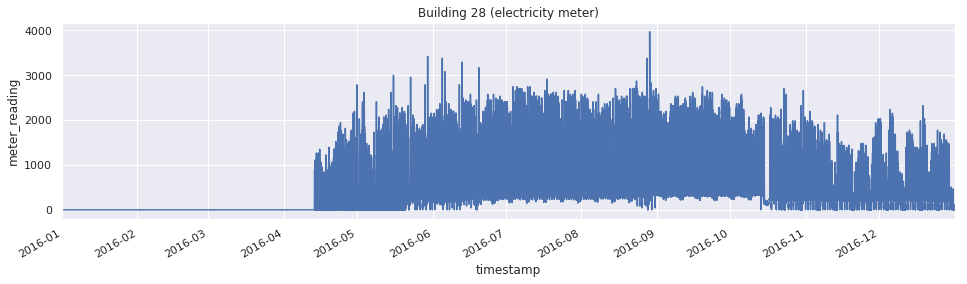

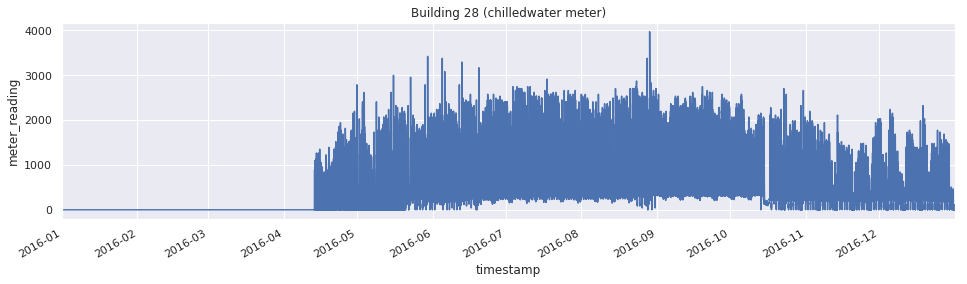

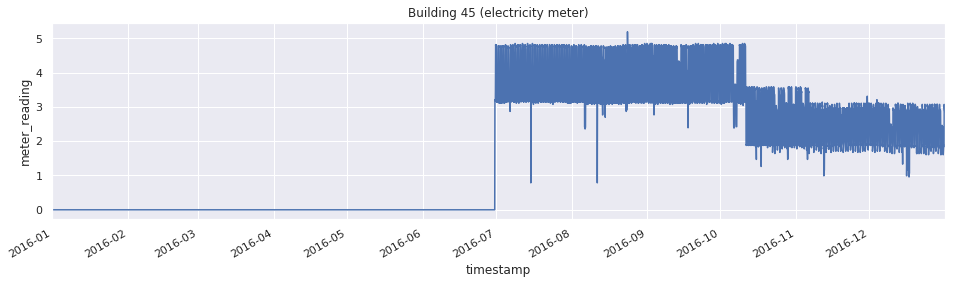

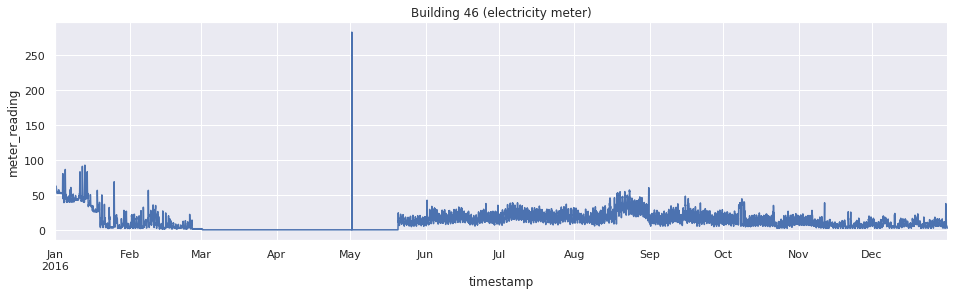

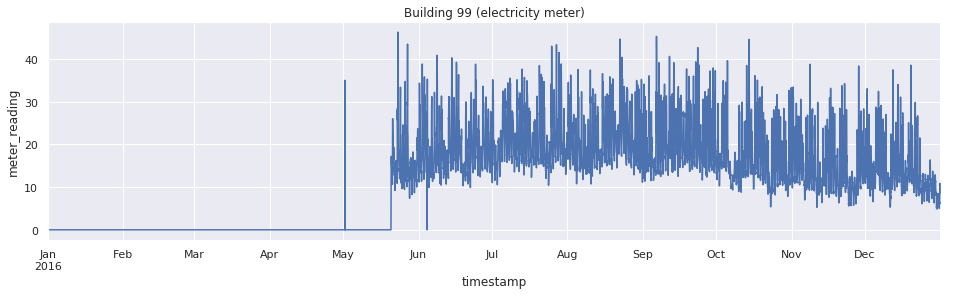

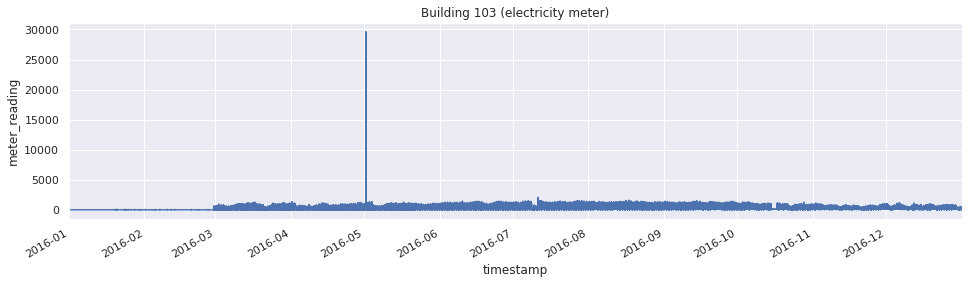

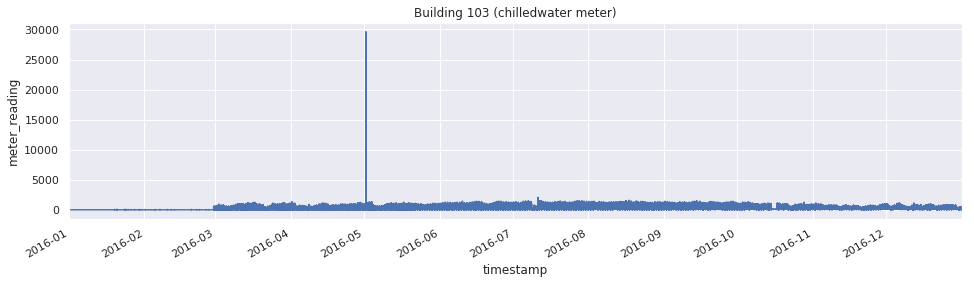

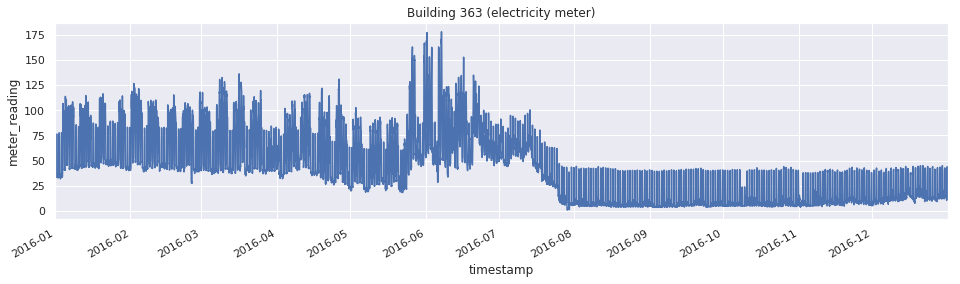

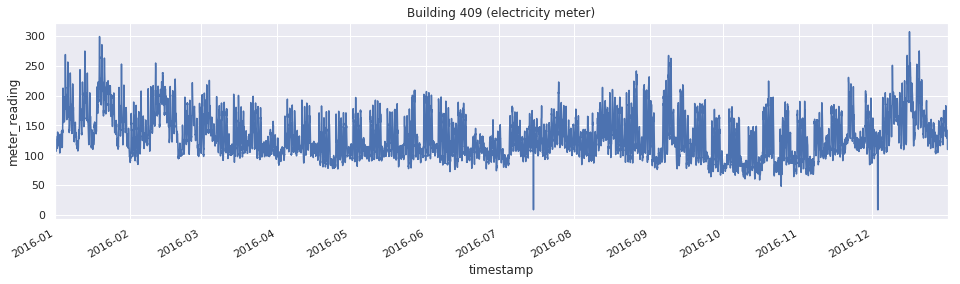

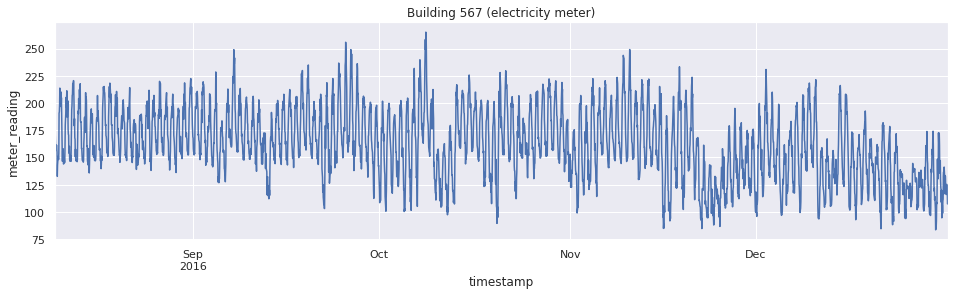

In [60]:
for bldg in construct.building_id:
    for type in bytime[bytime.building_id == bldg].type.unique():
        fig = plt.figure(figsize=(16, 4))
        bytime[bytime.building_id == bldg].meter_reading.plot()
        plt.ylabel('meter_reading')
        plt.title(f'Building {bldg} ({type} meter)')

About the 2016/2017 buildings:
- All of these buildings have an electricity meter
- None of the buildings show any similarities in electricity usage, despite some of them being in the same site
- The readings from 2 different meters in building 103 are producing the same exact plot, which is probably an error
- There are outliers (likely errors) in 4 meters that cause a peak in an otherwise flat section of the plot
- There are dips that deviate from the general usage pattern in 3 meters
- All the meters in site 0 have a period of time stretching several months, where the meter readings stay at 0 (except for the outliers)
    - This could signify a period of non-operation or it could just be an error in data collection
- Building 567 in site 4 is missing meter readings from the first 7 months

It may be best to just remove these 8 buildings from the data.

##### Remove all buildings that opened in either 2016 or 2017

In [61]:
for bldg in construct.building_id:
    bytime = bytime[bytime.building_id != bldg]
    
bytime.shape

(20137746, 4)

In [62]:
del construct, bldg, fig